# Setup

In [1]:
# Import packages
import os
import PIL
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# Globals
batch_size = 32
img_height = 180
img_width = 180
num_classes = 5
epochs = 20

AUTOTUNE = tf.data.experimental.AUTOTUNE

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

# Setup input pipeline

Dataset dir:
```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [3]:
# Download dataset dir
data_dir = tf.keras.utils.get_file("flower_photos", origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

# Count images
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


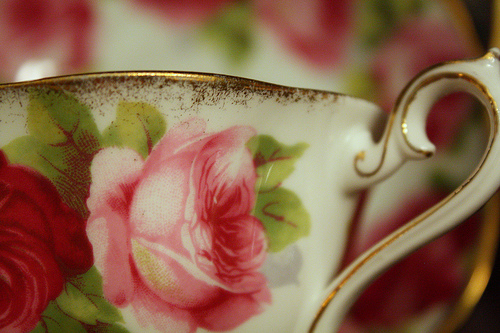

In [4]:
# View
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

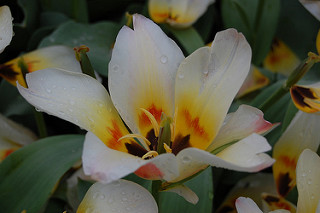

In [5]:
# View
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

In [6]:
# Create train and validation dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


## Visualize the data

Here are the first 9 images from the training dataset.

In [7]:
# Class labels
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


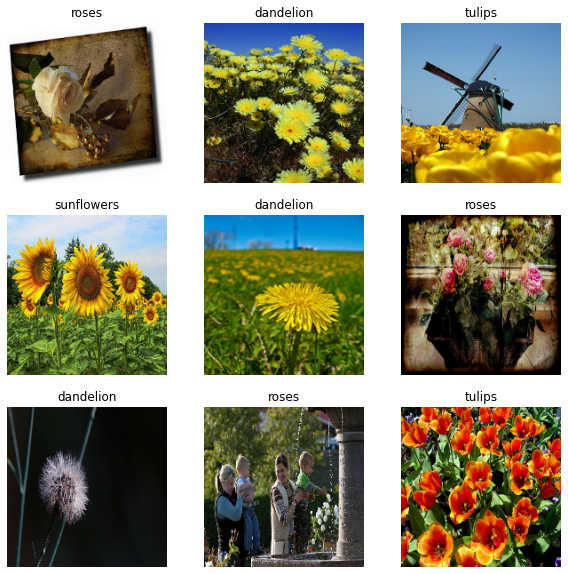

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
# View batched datatset
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


## Configure the dataset for performance

In [10]:
# Optimized datatsets
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Data Normalization

In [11]:
# Create image normalization layer to be used inside the model network
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

## Data augmentation

In [12]:
# Create a data augmentation pipeline
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal",
                                                     input_shape=(img_height,
                                                                  img_width,
                                                                  3)),
        layers.experimental.preprocessing.RandomRotation(0.2),
        layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

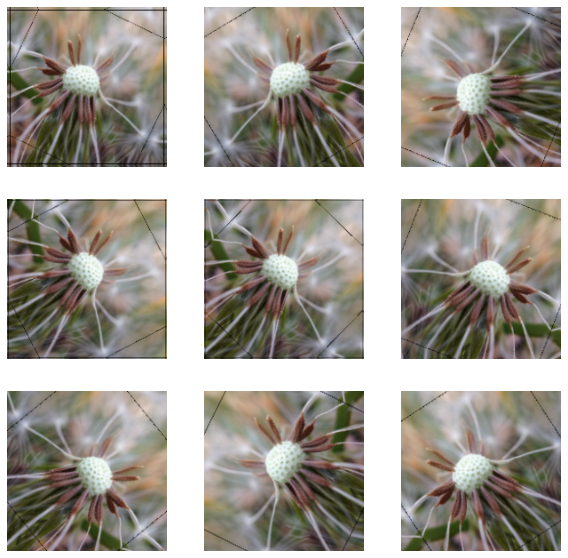

In [13]:
# Let's visualize a few augmented examples
plt.figure(figsize=(10, 10))

for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Modelling

In [14]:
# Create a sequential model classifier
model = Sequential([
    # Data Augmentation
    data_augmentation,
    
    # Data Normalizer
    layers.experimental.preprocessing.Rescaling(1./255),

    # Convolution layer
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, activation="sigmoid")
])

# Compile model
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])

# View
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)       

In [15]:
# Train and validate model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/20
92/92 [==============================] - 2s 26ms/step - loss: 1.4311 - accuracy: 0.4142 - val_loss: 1.2871 - val_accuracy: 0.5381
Epoch 2/20
92/92 [==============================] - 1s 13ms/step - loss: 1.3125 - accuracy: 0.5102 - val_loss: 1.2797 - val_accuracy: 0.5177
Epoch 3/20
92/92 [==============================] - 1s 13ms/step - loss: 1.2896 - accuracy: 0.5218 - val_loss: 1.2519 - val_accuracy: 0.5531
Epoch 4/20
92/92 [==============================] - 1s 13ms/step - loss: 1.2797 - accuracy: 0.5453 - val_loss: 1.2752 - val_accuracy: 0.5436
Epoch 5/20
92/92 [==============================] - 1s 13ms/step - loss: 1.2585 - accuracy: 0.5579 - val_loss: 1.2479 - val_accuracy: 0.5817
Epoch 6/20
92/92 [==============================] - 1s 12ms/step - loss: 1.2396 - accuracy: 0.5800 - val_loss: 1.2263 - val_accuracy: 0.5926
Epoch 7/20
92/92 [==============================] - 1s 12ms/step - loss: 1.2285 - accuracy: 0.5838 - val_loss: 1.2396 - val_accuracy: 0.5681
Epoch 8/20
92

## Visualize results

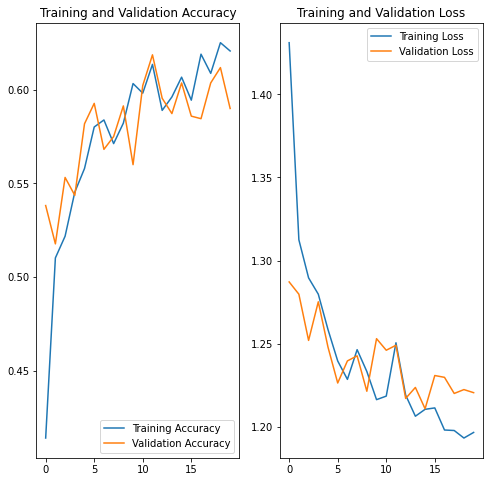

In [16]:
epochs_range = range(epochs)

# Plot accuracy
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

# Plot losses
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()